### Create a simple example non-parametric UMAP embedding 
- ...to look at what structure is learned by the nearest neighbors graph
- this notebook is hack-y, a parametric implementation is more appropriate here
- TODO
    - in graph construction, for the first and last chunks, we only have 1 set of nearest neighbors (i.e. half as many)
- note that we are ignoring the actual distances between points, and only retaining the nearest neighbors graph

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path
import spikeinterface.full as si
import probeinterface
from probeinterface.plotting import plot_probe
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from umap import UMAP
from umap.umap_ import nearest_neighbors, check_random_state


In [7]:
base_folder = Path('/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/')
peak_folder = base_folder / 'spikeinterface_peaks'

In [8]:
nn_idx = np.load(peak_folder / 'nearest_neighbor_index.npy')
nn_dist = np.load(peak_folder / 'nearest_neighbor_distances.npy')

### Create a sparse matrix from nn graph

In [12]:
from scipy.sparse import coo_matrix

In [42]:
from tqdm.auto import tqdm

In [48]:
# HACK: since we only have 5 neighbors for some elements in the matrix, 
#   we are sampling only 5 neighbors from *each* element
n_neighbors=5
neighbor_index = np.zeros((len(nn_idx), n_neighbors))
for ii, nns in enumerate(tqdm(nn_idx)):
    unique_nns = np.unique(nns)
    if len(unique_nns) < n_neighbors:
        print('too few connections')
        breakme
        # randomly sample some connections
        vals = np.concatenate(
            [unique_nns, np.arange(ii + 1, ii + 1 + n_neighbors - len(unique_nns))]
        )
        neighbor_index[ii] = vals
        #if np.any(vals) == i:
        #    breakme
    else:
        neighbor_index[ii] = np.random.choice(unique_nns, n_neighbors, replace=False)

  0%|          | 0/221083 [00:00<?, ?it/s]

In [49]:
# get values of matrix as rows and columns to input to scipy sparse matrix function
rows = neighbor_index.flatten()
cols = np.repeat(np.arange(len(neighbor_index)), n_neighbors)
rows_ = np.concatenate([rows, cols])
cols_ = np.concatenate([cols, rows])
rows.shape, cols.shape

((1105415,), (1105415,))

In [50]:
# create coo matrix
nearest_neighbors_graph = coo_matrix(
    (np.ones(len(rows_)), (rows_, cols_)), shape=(len(neighbor_index), len(neighbor_index))
)
# create csr
nearest_neighbors_graph_csr = nearest_neighbors_graph.tocsr()

In [54]:
embedder_from_nearest_neighbor = UMAP(
    metric="precomputed", verbose=True, n_neighbors=n_neighbors
)

### Embed precomputed distance matrix with UMAP

In [55]:
z_umap_from_nn = embedder_from_nearest_neighbor.fit_transform(nearest_neighbors_graph_csr)

/n/groups/datta/tim_sainburg/conda_envs/spikeinterface/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


UMAP(metric='precomputed', n_neighbors=5, verbose=True)
Wed Mar  9 15:26:01 2022 Construct fuzzy simplicial set
Wed Mar  9 15:26:29 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Mar  9 15:29:42 2022 Finished embedding


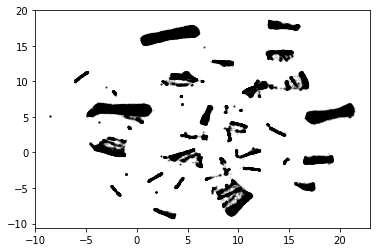

In [56]:
plt.scatter(z_umap_from_nn[:,0], z_umap_from_nn[:,1], s=1, color='k', alpha = 0.1)

### Plot with features

In [61]:
peak_folder = base_folder / 'spikeinterface_peaks'
peaks_file = peak_folder / 'peaks.npy'
peaks = np.load(peaks_file)

In [62]:
peak_location_file = peak_folder / 'peak_locations_monopolar_triangulation.npy'
peak_locations = np.load(peak_location_file)

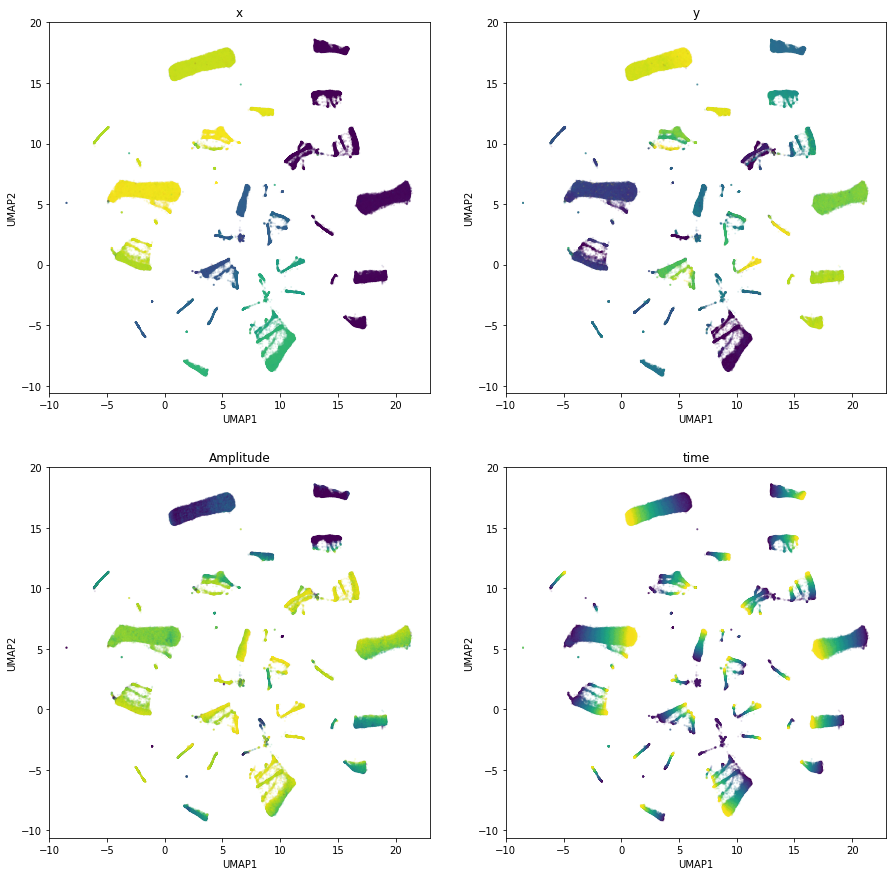

In [63]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
for axi, (title, data) in enumerate([
    ("x", peak_locations['x']), 
    ("y", peak_locations['y']), 
    ("Amplitude", peaks['amplitude']), 
    ("time", peaks['sample_ind']), 
]):
    ax = axs.flatten()[axi]
    ax.scatter(
        z_umap_from_nn[:, 0],
        z_umap_from_nn[:, 1],
        s=1,
        c=data,
        cmap=plt.cm.viridis,
        vmin=np.percentile(data, 5),
        vmax=np.percentile(data, 95),
        alpha=0.1,
    )
    ax.set_title(title)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

### Cluster

In [64]:
import hdbscan
import seaborn as sns

In [65]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000)

In [66]:
clusterer.fit(z_umap_from_nn)

HDBSCAN(min_cluster_size=1000)

In [67]:
N = len(np.unique(clusterer.labels_))
print(N)

27


In [68]:
from distinctipy import distinctipy

In [69]:
colors = distinctipy.get_colors(N)
colors[0] = (0.9,0.9,0.9)

In [70]:
color_dict = dict(zip(np.unique(clusterer.labels_), colors))

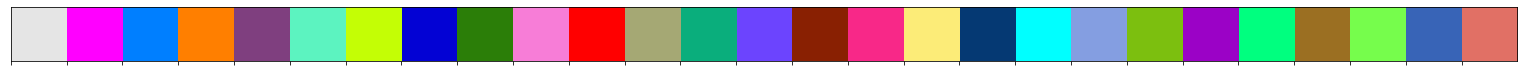

In [71]:
sns.palplot(colors)

In [72]:
c = [color_dict[i] for i in clusterer.labels_]

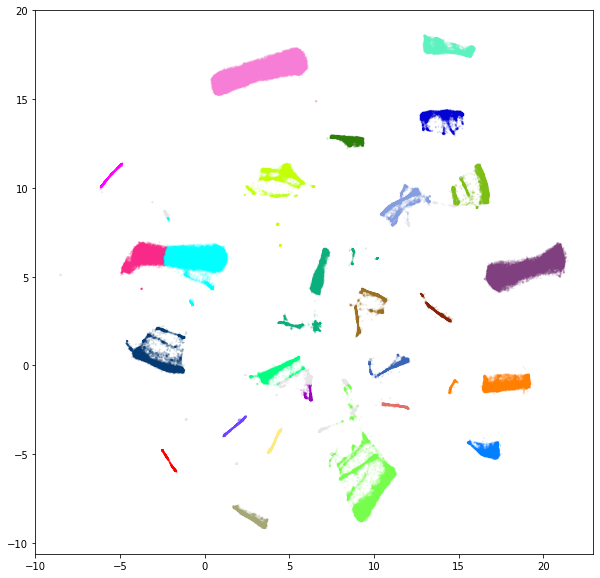

In [73]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    z_umap_from_nn[:, 0],
    z_umap_from_nn[:, 1],
    s=1,
    c=c,
    alpha=0.1,
)

### Plot over locations

In [76]:
preprocess_folder = base_folder / 'spikeinterface-preprocess'

In [77]:
# load back
rec = si.load_extractor(preprocess_folder)

(-150.0, 200.0)

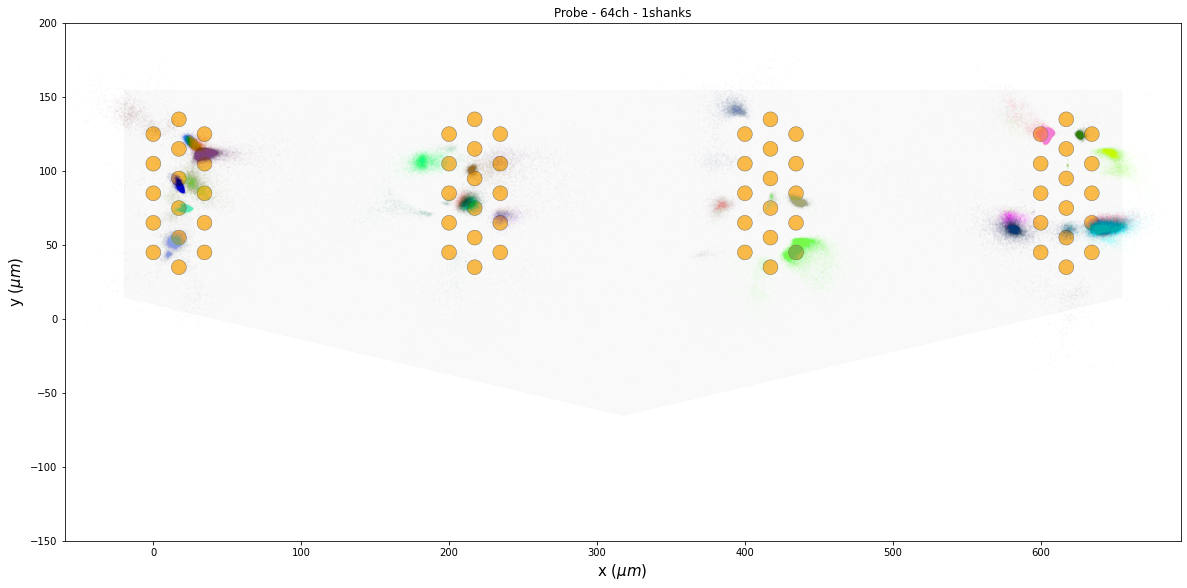

In [78]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_probe(rec.get_probe(), ax=ax, probe_shape_kwargs={
    'facecolor': (0,0,0,0.01),
    'alpha':0.025
})
ax.scatter(peak_locations["x"], peak_locations["y"], c=c, s=1, alpha=0.01)
ax.set_ylim(-150, 200)